<a href="https://www.kaggle.com/code/hadisraad/towards-parkinson-s-freezing-of-gait-prediction?scriptVersionId=137108244" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1>Predicting Parkinson's Freezing of Gait Episodes: A Comprehensive Step-by-Step Approach</h1>

Objective: the development of a model to predict Parkinson's freezing-of-gait episodes
<br>
<br>
<h3><b>Table of Contents</b></h3>


1. [Introduction](#section-1) <br>
2. [The Big Picture](#section-2) <br>
3. [Data Collection](#section-3) <br>
4. [Data Exploration](#section-4) <br>
5. [Data Preprocessing](#section-5) <br>
    5.1. [Handling Missing Data](#section-6) <br>
    5.2. [Handling Categorical Variables](#section-7) <br>
    5.3. [Data Normalization](#section-15) <br>
    5.3. [Outlier Detection](#section-8) <br>
6. [Feature Engineering](#section-9) <br>
7. [Model](#section-10) <br>
   7.1. [Model Selection](#section-11)<br>
   7.2. [Model Training](#section-12)<br>
   7.3. [Model Evaluation](#section-13)<br>
8. [Prediction and Submission](#section-14) <br>

<a id="section-1"></a>
<h3>1. Introduction</b></h3>


<div style="text-align: justify"> Freezing of gait (FOG) is a debilitating symptom that affects individuals diagnosed with Parkinson’s disease, which significantly impacting their ability to walk and limiting their mobility and independence. Machine learning (ML) techniques can provide valuable insights into the occurrence and causes of FOG episodes. By leveraging ML, medical professionals can enhance their evaluation, monitoring, and prevention of FOG events.


This notebook is based on <a href=https://www.kaggle.com/competitions/tlvmc-parkinsons-freezing-gait-prediction> Parkinson's Freezing of Gait Prediction competition</a> dataset which includes data collected from a wearable 3D lower back sensor. The goal of this project is detecting the start and stop of each freezing episode, as well as identifying three types of FOG events: Start Hesitation, Turn, and Walking.

</div>

<a id="section-2"></a>
<h3>2. The Big Picture</b></h3>

<div style="text-align: justify">The objective is to develop a model to detect and predict Parkinson's FOG episodes. These episodes will be predicted based on time series data that was recorded for each patient during the execution of a specific protocol in addition to some provided patient characteristics.</div>

<div style="text-align: justify">Given the availability of labeled targets in the dataset, a supervised learning approach is suitable for addressing this problem. Since there are multiple targets (Start Hesitation, Turn, and Walking), the problem is a <b>multi-class classification</b>. The evaluation metric in this project is the mean average precision, which measures the average precision of predictions for each event class. Thus, accurate predictions of correct event types are more important than predicting all events correctly.<br>
Considering these requirements, this notebook presents a LightGBM (Light Gradient Boosting Model) model developed specifically to optimize the desired evaluation metric.</div>

<a id="section-3"></a>
<h3>3. Data Collection</h3>

<div style="text-align: justify">Each patient in the dataset is considered as a subject. The dataset includes two types of experiments conducted to assess conditions of the patient:

1. TDCSFOG dataset: This dataset consists of data series collected in a lab, where subjects completed a FOG-provoking protocol.
1. DeFOG dataset: This dataset comprises data series collected in the subject's home, where the subject also completed a FOG-provoking protocol.
    

<div style="text-align: justify">The identification of each series in the TDCSFOG dataset is provided in the "tdcsfog_metadata.csv" file. Each series is uniquely identified by the Subject, Visit, Test, and Medication condition. Similarly, the identification of each series in the DeFOG dataset is given in the "defog_metadata.csv" file, supplied by unique identifiers for Subject, Visit, and Medication condition. For further details, the reader may refer to the <a href= https://www.kaggle.com/competitions/tlvmc-parkinsons-freezing-gait-prediction/data>dataset description page</a>. </div>

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import numpy as np
import pandas as pd
import glob
import math
import seaborn as sns
import lightgbm as lgb
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from tqdm.auto import tqdm
from os import path
from pathlib import Path

from sklearn.model_selection import GroupKFold
from sklearn.base import clone
from sklearn.metrics import average_precision_score

In [3]:
def reduce_memory_usage(df):
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype.name
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
            if (col_type != 'object'):
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        pass
            else:
                df[col] = df[col].astype('category')
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage became: ",mem_usg," MB")
    
    return df

In [4]:
# utility functions
def get_num_cols(df):
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    return numeric_columns


def factorize_column(column):
    if column.dtype == "category" or column.dtype == "object":
        return pd.factorize(column)[0]
    return column


In [5]:
root = "/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/"

train_defog = glob.glob(os.path.join(root, "train", "defog", "**"))
train_tdcsfog = glob.glob(os.path.join(root, "train", "tdcsfog", "**"))
test_defog = glob.glob(os.path.join(root, "test", "defog", "**"))
test_tdcsfog = glob.glob(os.path.join(root, "test", "tdcsfog", "**"))

subjects_df = pd.read_csv(os.path.join(root, "subjects.csv"))

tdcsfog_metadata = pd.read_csv(os.path.join(root, "tdcsfog_metadata.csv"))
defog_metadata = pd.read_csv(os.path.join(root, "defog_metadata.csv"))

#  events data which shows information of every FOG episodes
events_df = pd.read_csv(os.path.join(root, "events.csv"))

In [6]:
tdcsfog_metadata = tdcsfog_metadata.rename(
    columns={
        "Subject": "subject",
        "Visit": "visit",
        "Test": "test",
        "Medication": "medication",
    }
)
defog_metadata = defog_metadata.rename(
    columns={"Subject": "subject", "Visit": "visit", "Medication": "medication"}
)
subjects_df = subjects_df.rename(
    columns={
        "Subject": "subject",
        "Visit": "visit",
        "Age": "age",
        "Sex": "sex",
        "YearsSinceDx": "years_since_dx",
    }
)


In [7]:
defog_metadata_subjects = subjects_df.merge(
    defog_metadata, on=["subject", "visit"], how="inner"
)

tdcsfog_subjects = subjects_df.drop("visit", axis=1)
tdcsfog_metadata_subjects = tdcsfog_subjects.merge(
    tdcsfog_metadata, on=["subject"], how="inner"
)
tdcsfog_metadata_subjects = tdcsfog_metadata_subjects.drop("visit", axis=1)


<a id="section-4"></a>
<h3>4. Data Exploration</h3>

We first look at the subjects dataset.


In [8]:
subjects_df.head()

,subject,visit,age,sex,years_since_dx,UPDRSIII_On,UPDRSIII_Off,NFOGQ
0,00f674,2.0,63,M,27.0,43.0,49.0,24
1,00f674,1.0,63,M,27.0,31.0,30.0,26
2,02bc69,NaN,69,M,4.0,21.0,NaN,22
3,040587,2.0,75,M,26.0,52.0,69.0,21
4,040587,1.0,75,M,26.0,47.0,75.0,24


* "visit" is only available for subjects in the defog datasets.<br>
* "years_since_dx" represents years since the Parkinson's diagnosis.<br>
* UPDRSIIIOn (resp., UPDRSIIIOff) is Unified Parkinson's Disease Rating Scale score during on (resp., off) medication.<br>
* NFOGQ is a self-report FoG questionnaire score. <br>

In [9]:
defog_metadata_subjects

,subject,visit,age,sex,years_since_dx,UPDRSIII_On,UPDRSIII_Off,NFOGQ,Id,medication
0,00f674,2.0,63,M,27.0,43.0,49.0,24,41bc215f97,on
1,00f674,2.0,63,M,27.0,43.0,49.0,24,b4365bba9d,off
2,00f674,1.0,63,M,27.0,31.0,30.0,26,3f3b08f78d,off
3,00f674,1.0,63,M,27.0,31.0,30.0,26,4c3aa8ea6e,on
4,040587,2.0,75,M,26.0,52.0,69.0,21,2cc3c30645,on
...,...,...,...,...,...,...,...,...,...,...
132,e1f62e,2.0,79,F,8.0,38.0,64.0,28,9506859311,off
133,e86b6e,2.0,61,F,7.0,47.0,45.0,22,4ec23c3d98,off
134,e86b6e,2.0,61,F,7.0,47.0,45.0,22,a2f1a8ab76,on
135,f28337,1.0,72,M,16.0,52.0,50.0,18,139f60d29b,off


In [10]:
tdcsfog_metadata_subjects

,subject,age,sex,years_since_dx,UPDRSIII_On,UPDRSIII_Off,NFOGQ,Id,test,medication
0,02bc69,69,M,4.0,21.0,NaN,22,0330ea6680,1,on
1,02bc69,69,M,4.0,21.0,NaN,22,28cb22c5e2,2,on
2,02bc69,69,M,4.0,21.0,NaN,22,7da39fd09f,3,on
3,02bc69,69,M,4.0,21.0,NaN,22,99e5902ff6,2,on
4,02bc69,69,M,4.0,21.0,NaN,22,ef3651a9b5,1,on
...,...,...,...,...,...,...,...,...,...,...
828,fa8764,60,F,7.0,30.0,NaN,19,8797749a82,1,on
829,fa8764,60,F,7.0,30.0,NaN,19,98c313f19c,1,on
830,fa8764,60,F,7.0,30.0,NaN,19,d2382704e0,2,on
831,fa8764,60,F,7.0,30.0,NaN,19,dbe0a8f2fd,2,on


Since different tests were conducted in each visit, the metadata size for TDCSFOG is around 6 times larger than the DeFOG metadata.

In [11]:
print("The number of patients in DeFog metada:" ,
      len(pd.unique(defog_metadata_subjects["subject"])))

The number of patients in DeFog metada: 45


In [12]:
print("The number of patients in TDCSFog metada:" ,
      len(pd.unique(tdcsfog_metadata_subjects["subject"])))

The number of patients in TDCSFog metada: 62


For analyzing the information of all 107 patients, both defog and tdcsfog metadata are joined.


In [13]:
full_metadata = pd.concat([defog_metadata_subjects, tdcsfog_metadata_subjects], axis=0)

full_metadata.drop(["visit", "test"], axis=1, inplace=True)

full_metadata["sex"] = full_metadata["sex"].map({"F": 0, "M": 1})
full_metadata["medication"] = full_metadata["medication"].map({"on": 0, "off": 1})

              age  years_since_dx  UPDRSIII_On  UPDRSIII_Off       NFOGQ
count  970.000000      970.000000   967.000000    800.000000  970.000000
mean    68.091753       10.300000    35.201655     43.211250   17.953608
std      7.919932        5.952183    12.005506     14.362607    5.020383
min     28.000000        1.000000    13.000000     15.000000    0.000000
25%     64.000000        6.000000    27.000000     32.000000   15.000000
50%     68.000000       10.000000    37.000000     43.000000   19.000000
75%     73.000000       14.000000    43.000000     49.250000   21.000000
max     94.000000       30.000000    79.000000     91.000000   29.000000


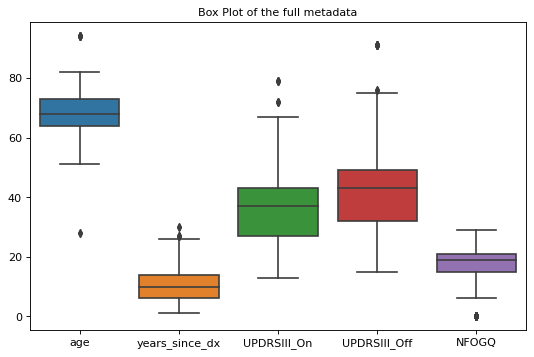

In [14]:
print(full_metadata[["age","years_since_dx","UPDRSIII_On","UPDRSIII_Off","NFOGQ"]].describe())

df=full_metadata[["age","years_since_dx","UPDRSIII_On","UPDRSIII_Off","NFOGQ"]].copy()
plt.figure(figsize=(8,5), dpi= 80)
sns.boxplot( data=df, notch=False)

plt.title('Box Plot of the full metadata', fontsize=10)

plt.show()

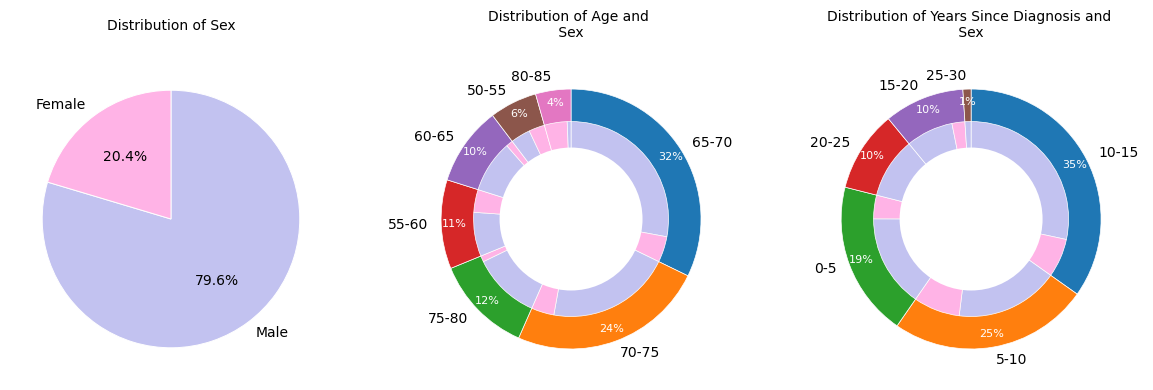

In [15]:
plt.style.use('default')

temp= full_metadata.copy()
temp.dropna(inplace=True)
temp=temp[temp['age']!=28]
temp.rename(columns={"years_since_dx":"Years Since Diagnosis"}, inplace=True)
temp['Age']=temp['age'].astype("int64")
temp['Years Since Diagnosis']=temp['Years Since Diagnosis'].astype("int64")
columns = ['Age', 'Years Since Diagnosis']

colors_gender = ['#c2c2f0','#ffb3e6']
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

counts = temp["sex"].value_counts()
gender_labels=["Male","Female"]
axes[0].pie(counts, labels=gender_labels,counterclock=False,startangle=90,autopct='%1.1f%%',
                 colors=colors_gender, wedgeprops={'edgecolor': 'white', 'linewidth': 0.7})
axes[0].set_title('Distribution of Sex', pad=20,fontdict={'fontsize': 10,'fontfamily':'Tahoma'})

for i, column in enumerate(columns):
    # Get the minimum and maximum values of the column
    min_value = temp[column].min()
    max_value = temp[column].max()

    min_value=5 * math.floor(min_value / 5)
    # Create age ranges using pd.cut()
    age_ranges = pd.cut(temp[column], bins=np.arange(min_value, max_value+5, 5), right=False,
                        labels=[f'{i}-{i+5}' for i in range(min_value, max_value, 5)])

    temp['Age Range'] = age_ranges

    counts = temp['Age Range'].value_counts()
    counts = counts.sort_values(ascending=False)
    
    # Sort the sizes_gender variable based on the sorting order of counts
    sizes_gender = temp.groupby('Age Range')['sex'].value_counts().reindex(counts.index, level=0)
    
    gender_counts = sizes_gender.index.get_level_values('sex')

    # Define the color map and assign colors based on gender counts
    colors = [colors_gender[0] if gender == 1 else colors_gender[1] for gender in gender_counts]

    wedges, texts, autotexts =axes[i+1].pie(counts, labels=counts.index,counterclock=False,startangle=90,
                  autopct='%1.0f%%',wedgeprops={'edgecolor': 'white', 'linewidth': 0.5})
    for autotext in autotexts:
        autotext.set_horizontalalignment('center') 
        autotext.set_verticalalignment('center')  
        autotext.set_position((1.5 * autotext.get_position()[0],1.5*autotext.get_position()[1]))
        autotext.set_fontsize(8)
        autotext.set_color('white')
    
    axes[i+1].set_title(f'Distribution of {column} and \n Sex ', pad=15,  fontdict={'fontsize': 10,'fontfamily':'Tahoma'})
    axes[i+1].pie(sizes_gender,colors=colors,radius=0.75,counterclock=False,startangle=90,
               wedgeprops={'edgecolor': 'white', 'linewidth': 0.5})
    
    centre_circle = plt.Circle((0,0),0.55,fc='white')
    axes[i+1].add_artist(centre_circle)
    # Equal aspect ratio ensures that pie is drawn as a circle
    axes[i+1].axis('equal')  

plt.tight_layout()
plt.show()


* Approximately 80% of the participants are men.
* More than 66% of the participants are between 65-75 years old.
* Around 60% of the participants were diagnosed 5-15 years ago.
* Among participants aged between 80-85, the majority are women.

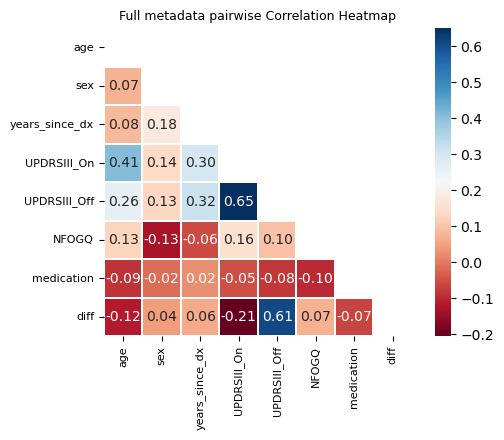

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

full_metadata["diff"] = full_metadata["UPDRSIII_Off"]-full_metadata["UPDRSIII_On"]

plt.figure(figsize=(6, 4))

# Compute the correlation matrix
numberic_columns= get_num_cols(full_metadata)
corr_matrix = full_metadata[numberic_columns].corr()

# Mask the diagonal elements
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

heatmap = sns.heatmap(corr_matrix, cmap='RdBu', annot=True, fmt='.2f', linewidths=0.15,
                      square=True,
                      mask=mask
                     )
plt.title('Full metadata pairwise Correlation Heatmap', fontsize=9)

heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=8)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=8)

plt.show()

A 'diff' column is added to display the difference between UPDRSIII_Off and UPDRSIII_On.

* There is a relationship between diff and age, which will be analyzed.
* Additionally, it seems reasonable to fill the missing values of UPDRSIII_Off (presented in the preprocessing part) since it has a strong relationship with UPDRSIII_On. It is also slightly correlated with years_since_dx, age, and sex.

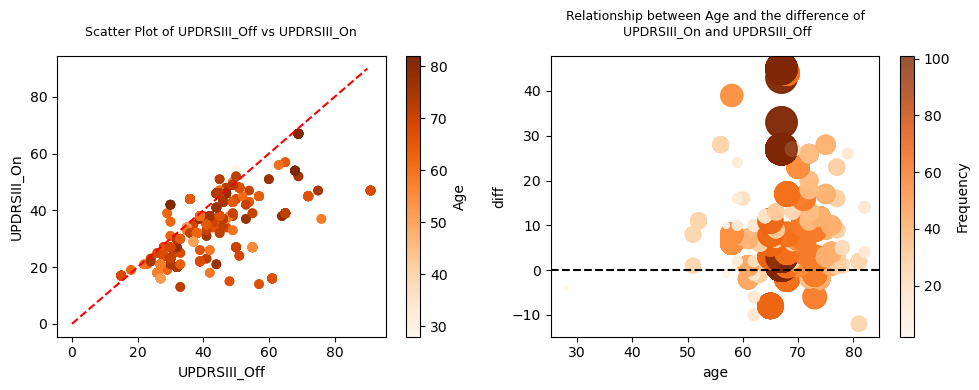

In [17]:

temp = full_metadata[~full_metadata['UPDRSIII_On'].isna()].sort_values("diff").copy()

age = temp['age']
diff = temp['diff']
frequency = temp['age'].value_counts()

cmap = plt.colormaps['Oranges']


fig = plt.figure(figsize=(10, 4))
# Define a custom grid layout for the subplots
grid = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
# Create the first subplot with a specific width
ax1 = plt.subplot(grid[0])


# Create a subplot for the scatter plot or line plot
plt.scatter(full_metadata['UPDRSIII_Off'], full_metadata['UPDRSIII_On'], c=full_metadata['age'], cmap='Oranges')
plt.xlabel('UPDRSIII_Off')
plt.ylabel('UPDRSIII_On')
plt.title('Scatter Plot of UPDRSIII_Off vs UPDRSIII_On', fontsize=9, pad=15)
plt.colorbar(label='Age')

plt.plot([0, 90], [0, 90], 'r--')  # Add a red dashed line from (0, 0) to (90, 90)



ax2 = plt.subplot(grid[1])
plt.subplot(1, 2, 2)
m=plt.scatter(age, diff, c=frequency[age].values, cmap=cmap, s=frequency[age].values*5, alpha=0.8)
plt.xlabel('age')
plt.ylabel('diff')
plt.title('Relationship between Age and the difference of\n UPDRSIII_On and UPDRSIII_Off', fontsize=9, pad=15)
plt.colorbar(mappable=m, label='Frequency')

# Add a horizontal line at y=0
plt.axhline(0, color='black', linestyle='--')  

plt.tight_layout() 
plt.show()

<div style="text-align: justify">As the plot above depicts, for the majority of cases, medication is effective in controlling UPDRSIII. However, in some cases, medication not only fails to be effective but also worsens the situation.<br>
In the next chart, the difference between UPDRSIII, when medication is on and when it is off, is calculated and compared to age. <b>For ages below 60, medication is almost universally effective</b>. However, for ages above 60, the effects vary greatly in a case-by-case manner. The most diversity is observed in the age range of 65-75 (as we saw before, 66% of patients are in this age group). In this age range, medication can either worsen the symptoms or be even more effective compared to other age ranges.</div>


The following trends can be observed with respect to the role of sex:


In [18]:
# women full metadata
temp = full_metadata.copy()
temp = temp[temp["sex"]==0]
temp["diff"]=temp["UPDRSIII_Off"]-temp["UPDRSIII_On"]

print("Average of UPDRSIII_Off in women: {:.2f}".format(temp["UPDRSIII_Off"].mean()))
print("Average of UPDRSIII_On in women: {:.2f}".format(temp["UPDRSIII_On"].mean()))

print("Average of difference between UPDRSIII_On and UPDRSIII_Off in women: {:.2f}".format(temp["diff"].mean()))
print("Ineffective medication cases in women: {:.2f} ".format((len(temp[temp["diff"]<0])/len(temp))*100))

Average of UPDRSIII_Off in women: 39.55
Average of UPDRSIII_On in women: 31.87
Average of difference between UPDRSIII_On and UPDRSIII_Off in women: 7.72
Ineffective medication cases in women: 12.24 


In [19]:
# men full metadata
temp = full_metadata.copy()
temp = temp[temp["sex"]==1]
temp["diff"]=temp["UPDRSIII_Off"]-temp["UPDRSIII_On"]

print("Average of UPDRSIII_Off in men: {:.2f}".format(temp["UPDRSIII_Off"].mean()))
print("Average of UPDRSIII_On in men: {:.2f}".format(temp["UPDRSIII_On"].mean()))
print("Average of difference between UPDRSIII_On and UPDRSIII_Off in men: {:.2f}".format(temp["diff"].mean()))
print("Ineffective medication cases in men: {:.2f}".format((len(temp[temp["diff"]<0])/len(temp))*100))

Average of UPDRSIII_Off in men: 44.16
Average of UPDRSIII_On in men: 36.03
Average of difference between UPDRSIII_On and UPDRSIII_Off in men: 8.92
Ineffective medication cases in men: 9.17


This analysis reveals the following insights:

* **Women generally exhibit a slightly better condition in Parkinson's disease.**
* **On the other hand, medication tends to be trivially more effective in men.**

Now, we investigate a time series dataset that includes all three types of FOG, i.e., Start Hesitation, Turn, and Walking.

In [20]:
# get file series Id that includes all three FOG episodes
desired_id = events_df.groupby("Id").filter(lambda x: all(item in x["Type"].values for item in ["StartHesitation", "Turn", "Walking"]))["Id"]
desired_id=pd.unique(desired_id)
 
sample_Id=[]
for file in train_tdcsfog:
        Id = file.split('/')[-1].split('.')[0]
        if Id in desired_id:
            sample_Id.append(Id)

sample_train_tdcsfog_series = pd.read_csv(root + '/train/tdcsfog/' + str(sample_Id[0]) + '.csv')
sample_train_tdcsfog_series

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
0,0,-8.955984,0.260610,-3.589704,0,0,0
1,1,-8.947311,0.255553,-3.558284,0,0,0
2,2,-8.943036,0.257540,-3.560648,0,0,0
3,3,-8.943387,0.266389,-3.585622,0,0,0
4,4,-8.936433,0.255044,-3.592390,0,0,0
...,...,...,...,...,...,...,...
9933,9933,-8.765176,-0.213985,-3.905432,0,0,0
9934,9934,-8.761039,-0.216697,-3.892081,0,0,0
9935,9935,-8.772187,-0.223224,-3.923688,0,0,0
9936,9936,-8.776302,-0.234185,-3.941642,0,0,0


This dataset is comprised of lower-back 3D accelerometer data which captures the following features related to FOG detection:

* AccV: acceleration measured by a vertical sensor
* AccML: acceleration measured by a mediolateral sensor
* AccAP: acceleration measured by an anteroposterior sensor

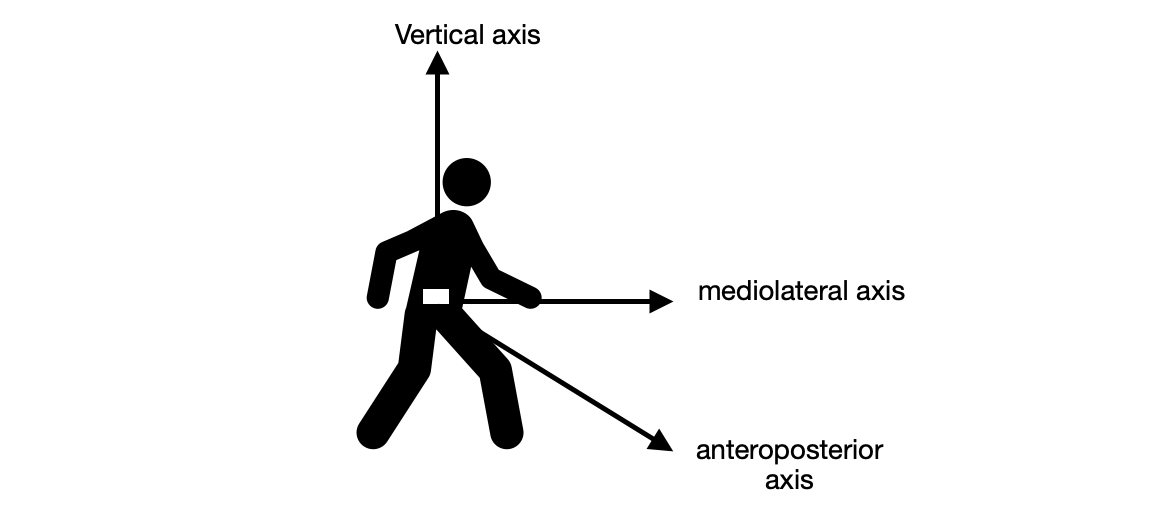
These three characteristics are the main feautures to detect FOG.


In [21]:
sample_train_tdcsfog_series.describe()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
count,9938.000000,9938.000000,9938.000000,9938.000000,9938.000000,9938.000000,9938.000000
mean,4968.500000,-9.534513,-0.070438,-0.505302,0.009861,0.362145,0.055645
std,2868.997822,0.820164,0.680315,1.487464,0.098817,0.480645,0.229246
min,0.000000,-14.193930,-2.589787,-6.515947,0.000000,0.000000,0.000000
25%,2484.250000,-9.844360,-0.445212,-0.764294,0.000000,0.000000,0.000000
50%,4968.500000,-9.545002,-0.016173,-0.139410,0.000000,0.000000,0.000000
75%,7452.750000,-8.918930,0.250765,0.279927,0.000000,1.000000,0.000000
max,9937.000000,-6.554793,2.761193,5.693978,1.000000,1.000000,1.000000


Since the range of acceleration data is different, a suitable normalization process may improve the model performance (presented in the preprocessing part).

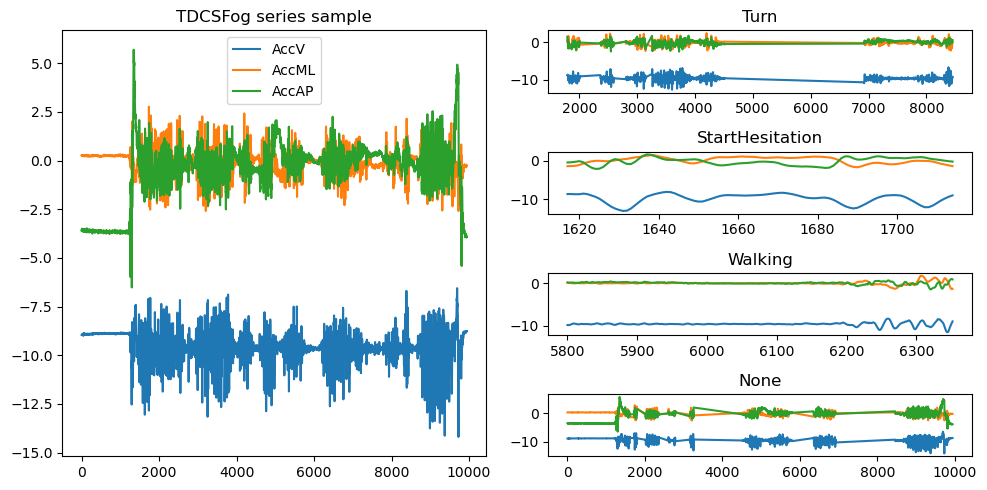

In [22]:
# Turn series
sample_tdcsfog_Turn= sample_train_tdcsfog_series[sample_train_tdcsfog_series["Turn"]==1]

# StartHesitation series
sample_tdcsfog_StartHesitation= sample_train_tdcsfog_series[sample_train_tdcsfog_series["StartHesitation"]==1]

# Walking series
sample_tdcsfog_Walking= sample_train_tdcsfog_series[sample_train_tdcsfog_series["Walking"]==1]

# None Event series
sample_tdcsfog_None= sample_train_tdcsfog_series[~((sample_train_tdcsfog_series["Walking"]==1) |
                                                    (sample_train_tdcsfog_series["StartHesitation"]==1)|
                                                    (sample_train_tdcsfog_series["Turn"]==1))]

# # Create the 4*2 grid of subplots
grid = (4, 2)
fig = plt.figure(figsize=(10, 5))

# # Create the first pie chart spanning cells (1,1) and (2,1) and (3,1) and(4,1)
ax1 = plt.subplot2grid(grid, (0, 0), rowspan=4, colspan=1)

ax1.plot(sample_train_tdcsfog_series["Time"], sample_train_tdcsfog_series["AccV"], label="AccV")
ax1.plot(sample_train_tdcsfog_series["Time"], sample_train_tdcsfog_series["AccML"], label="AccML")
ax1.plot(sample_train_tdcsfog_series["Time"], sample_train_tdcsfog_series["AccAP"], label="AccAP")

ax1.legend()

ax1.set_title("TDCSFog series sample")

ax2 = plt.subplot2grid(grid, (0, 1))

# Plot sample_tdcsfog_Turn in the second column
ax2.plot(sample_tdcsfog_Turn["Time"], sample_tdcsfog_Turn[["AccV", "AccML", "AccAP"]])
ax2.set_title("Turn")

ax3 = plt.subplot2grid(grid, (1, 1))
# Plot sample_tdcsfog_StartHesitation in the second column
ax3.plot(sample_tdcsfog_StartHesitation["Time"], sample_tdcsfog_StartHesitation[["AccV", "AccML", "AccAP"]])
ax3.set_title("StartHesitation")

ax4 = plt.subplot2grid(grid, (2, 1))
# Plot sample_tdcsfog_Walking in the second column
ax4.plot(sample_tdcsfog_Walking["Time"], sample_tdcsfog_Walking[["AccV", "AccML", "AccAP"]])
ax4.set_title("Walking")

ax4 = plt.subplot2grid(grid, (3, 1))
# Plot sample_tdcsfog_None in the second column
ax4.plot(sample_tdcsfog_None["Time"], sample_tdcsfog_None[["AccV", "AccML", "AccAP"]])
ax4.set_title("None")

# Adjust spacing between subplots
plt.tight_layout()

plt.show()


<div style="text-align: justify">In a particular time series, we observe that the variation of acceleration data during the Turn episode is at its maximum, which is a reasonable expectation. However, what makes the prediction challenging is the observation of non-trivial variations even in the absence of Turn, Walking, or Start Hesitation episodes. This variability in the data adds complexity to the prediction task.</div>

<a id="section-5"></a>
<h3>5. Data Preprocessing</h3>

<a id="section-6"></a>
<h4>5.1. Handling Missing Data</h4>

In [23]:
print("Null values in Subjects dataset:")
subjects_df.isna().sum()

Null values in Subjects dataset:


subject            0
visit             62
age                0
sex                0
years_since_dx     0
UPDRSIII_On        1
UPDRSIII_Off      41
NFOGQ              0
dtype: int64

It is mentioned in the data description that visit column was filled just for deFOG series, so no action is required for this field. But UPDRSIII_Off and UPDRSIII_On columns have to be filled with suitable data.

In [24]:
full_metadata

,subject,age,sex,years_since_dx,UPDRSIII_On,UPDRSIII_Off,NFOGQ,Id,medication,diff
0,00f674,63,1,27.0,43.0,49.0,24,41bc215f97,0,6.0
1,00f674,63,1,27.0,43.0,49.0,24,b4365bba9d,1,6.0
2,00f674,63,1,27.0,31.0,30.0,26,3f3b08f78d,1,-1.0
3,00f674,63,1,27.0,31.0,30.0,26,4c3aa8ea6e,0,-1.0
4,040587,75,1,26.0,52.0,69.0,21,2cc3c30645,0,17.0
...,...,...,...,...,...,...,...,...,...,...
828,fa8764,60,0,7.0,30.0,NaN,19,8797749a82,0,NaN
829,fa8764,60,0,7.0,30.0,NaN,19,98c313f19c,0,NaN
830,fa8764,60,0,7.0,30.0,NaN,19,d2382704e0,0,NaN
831,fa8764,60,0,7.0,30.0,NaN,19,dbe0a8f2fd,0,NaN


In [25]:
print("The null percentage of UPDRSIII_Off:{:.2f}%".format(full_metadata["UPDRSIII_Off"].isna().sum()/len(full_metadata)*100))

The null percentage of UPDRSIII_Off:17.53%


In [26]:
full_metadata.isna().sum()

subject             0
age                 0
sex                 0
years_since_dx      0
UPDRSIII_On         3
UPDRSIII_Off      170
NFOGQ               0
Id                  0
medication          0
diff              173
dtype: int64

<div style="text-align: justify">As we saw in the correlation matrix, UPDRSIII_Off strongly correlates with UPDRSIII_On. It is also slightly correlated with years_since_dx, age, and sex. So, filling missing values of UPDRSIII_Off and UPDRSIII_On using an imputation scheme seems to be reasonable. For this porpose, we employ the MICE (Multivariate Imputation by Chained Equations) algorithm that considers relationships between variables.

In [27]:
# Imputing using MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

full_metadata_temp= full_metadata.loc[:,['Id','UPDRSIII_Off',"UPDRSIII_On","years_since_dx","age","sex"]].copy()

columns_to_update=['UPDRSIII_Off','UPDRSIII_On']
df_mice = full_metadata_temp.filter(columns_to_update, axis=1).copy()

# Define MICE imputer and fill missing values
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None,
                                imputation_order='ascending')

df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)
# Update the columns in the original DataFrame with the imputed values
full_metadata_temp.update(df_mice_imputed[columns_to_update])

In [28]:
tdcsfog_metadata_subjects.copy()
temp=tdcsfog_metadata_subjects.drop(["UPDRSIII_Off","UPDRSIII_On"], axis=1)

merged_df = temp.merge(full_metadata_temp, on='Id', how='left')

# Fill the null values in column 'c1' of df1 with the values from merged_df
tdcsfog_metadata_subjects['UPDRSIII_Off'].fillna(merged_df['UPDRSIII_Off'], inplace=True)
tdcsfog_metadata_subjects['UPDRSIII_On'].fillna(merged_df['UPDRSIII_On'], inplace=True)

In [29]:
tdcsfog_metadata_subjects.isna().sum()

subject           0
age               0
sex               0
years_since_dx    0
UPDRSIII_On       0
UPDRSIII_Off      0
NFOGQ             0
Id                0
test              0
medication        0
dtype: int64

In [30]:
defog_metadata_subjects.isna().sum()

subject           0
visit             0
age               0
sex               0
years_since_dx    0
UPDRSIII_On       0
UPDRSIII_Off      0
NFOGQ             0
Id                0
medication        0
dtype: int64

<a id="section-7"></a>
<h4>5.2. Converting Categorical Features</h4>

In [31]:
full_metadata.dtypes

subject            object
age                 int64
sex                 int64
years_since_dx    float64
UPDRSIII_On       float64
UPDRSIII_Off      float64
NFOGQ               int64
Id                 object
medication          int64
diff              float64
dtype: object

In [32]:
defog_metadata_subjects["sex"] = defog_metadata_subjects["sex"].map({'F' :0, 'M' :1})
tdcsfog_metadata_subjects["sex"]= tdcsfog_metadata_subjects["sex"].map({'F' :0, 'M' :1})

defog_metadata_subjects["medication"] = defog_metadata_subjects["medication"].map({'on' :0, 'off' :1})
tdcsfog_metadata_subjects["medication"] = tdcsfog_metadata_subjects["medication"].map({'on' :0, 'off' :1})


Since real values of 'subject' and 'Id' are needed in the next part, they will be converted later.

<a id="section-16"></a>
<h4>5.3. Normalizing Data</h4>

The acceleration data needs to be normalized. The normalization takes place in the model method for the purpose of achieving a better performance.

In [33]:
def normalize_columns(df, columns):
    min_values = df[columns].min()
    max_values = df[columns].max()

    normalized_df = (df[columns] - min_values) / (max_values - min_values)
    return normalized_df

<a id="section-8"></a>
<h4>5.4. Outliers</h4>

To find the event that takes more than usual time, the distributaion of each FOG event is illustrated by a boxplot.

In [34]:
events_df['duration'] = events_df['Completion'] - events_df['Init']

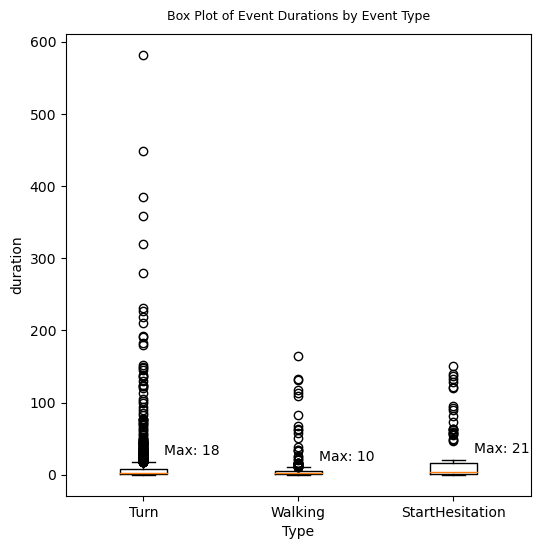

In [35]:
plt.style.use('default')

events_arr = events_df['Type'].unique()
# Remove NaN values
series = pd.Series(events_arr)
series_without_nan = series.dropna()
events_arr = series_without_nan.to_numpy()

plt.figure(figsize=(6, 6))
box_plot=plt.boxplot([events_df[events_df['Type'] == t]['duration'] for t in events_arr],
            labels=events_arr)
plt.xlabel('Type')
plt.ylabel('duration')
plt.title('Box Plot of Event Durations by Event Type', fontsize=9, pad=10)

# Annotate the minimum and maximum values for each box plot
for i, box in enumerate(box_plot['boxes']):

    max_val = box_plot['whiskers'][i*2 + 1].get_ydata()[1]
    
    plt.annotate(f"Max: {max_val:.0f}", (i+1, max_val), xytext=(10+25, +5), textcoords='offset points', ha='center')

plt.show()

Data points that fall outside the whiskers can be considered as outliers. However, during the fine-tuning of the model, a temporal threshold larger than 200 seconds, to detect event outliers, seems to be ideal.

In [36]:
#  delete outliers

# Get the maximum value for each type from the box plot
max_values = {t: item.get_ydata()[1] for t, item in zip(events_df['Type'].unique(), box_plot['whiskers'][1::2])}

# Drop rows with durations greater than the maximum value for each type
events_filtered = events_df.groupby('Type').apply(lambda x: x[x['duration'] >= (max_values[x['Type'].unique()[0]])+200]).reset_index(drop=True)


<a id="section-9"></a>
<h3>6. Feature Engineering</h3>

<div style="text-align: justify">Because acceleration data are the most important feautures to detect an event, some new features related to these features are added to the data. Some statistics can be calculated for time series data based on a sliding window that moves along the data range. The size of this window is considered 1024.

These new features are:

* **acc_sum**: Sum of the "AccV", "AccML", and "AccAP" features
* **time_frac**: The fraction of time relative to the maximum time value in the series
* **cum_sum**: The cumulative sum of Acc features

Rolling features of each Acc features associated with a specified window length are as follows.
* **rolling_sum**
* **rolling_min**
* **rolling_max**
* **rolling_mean**
* **rolling_std**
* **rolling_delta**: The difference between the rolling maximum and the rolling minimum <br>
    
Lead and lag differences for each Acc feature are listed below.  
* **acc_lead_diff**: The time difference between the current data point and the previous data point 
* **acc_lag_diff**:The time difference between the current data point and the next data point



In [37]:

def reader(file, module, pre_type=None):
    if module=="tdcsfog":
        window_length =4048
    elif module=="defog":
        window_length=4048
    try:

        df = pd.read_csv(file)

        path_split = file.split('/')
        Id = path_split[-1].split('.')[0]
        df['Id'] = Id
        
        if module=="defog":
            data= df.merge(defog_metadata_subjects,how="left",on="Id")
            if 'Valid' in data.columns and 'Task' in data.columns and pre_type=="train":
                data = data.loc[(data['Valid'] == True) & (data["Task"] == True)]
                data.drop(["Valid", "Task"], axis=1, inplace=True)
            elif 'Valid' in data.columns and 'Task' in data.columns:
                data.drop(["Valid", "Task"], axis=1, inplace=True)

        elif module == "tdcsfog":
            data= df.merge(tdcsfog_metadata_subjects,how="left",on="Id")

        data["acc_sum"]= data["AccV"]+data["AccML"]+data["AccAP"]
        data['time_frac']=(data["Time"]/data["Time"].max()).values
        acc_columns=["AccV","AccML","AccAP"]
        
        columns_to_normalize = ['AccV', 'AccML', 'AccAP']
        data[columns_to_normalize] = normalize_columns(data, columns_to_normalize)   
        
        for acc in acc_columns:
            data[f'{acc}_cumsum'] = data[acc].cumsum()
            data[f'{acc}_rolling_sum'] = data[acc].rolling(window=window_length, min_periods=1).sum()
            data[f'{acc}_rolling_min'] = data[acc].rolling(window=window_length, min_periods=1).min()
            data[f'{acc}_rolling_max'] = data[acc].rolling(window=window_length, min_periods=1).max()
            data[f'{acc}_rolling_mean'] = data[acc].rolling(window=window_length, min_periods=1).mean()
            data[f'{acc}_rolling_std'] = data[acc].rolling(window=window_length, min_periods=1).std()
            data[f'{acc}_rolling_delta'] = data[f'{acc}_rolling_max'] - data[f'{acc}_rolling_min']        
            data[f'{acc}_EWMA_02'] = data[acc].ewm(alpha=0.2).mean()
        
        for c in acc_columns:
            data[f"{c}_lead_diff"] = data[c].diff(-1)
            data[f"{c}_lag_diff"] = data[c].diff()


        data.fillna(method='backfill', inplace=True)
        
#         for train data 
        events_id = events_filtered[events_filtered["Id"] == Id]

        events_rows = pd.DataFrame()
        if len(events_id)>0:
            return None
                
        return data
    except: pass

In [38]:
train_defog_df = pd.concat([reader(f,"defog","train") for f in tqdm(train_defog)]).fillna(-1); print(train_defog_df.shape)

  0%|          | 0/91 [00:00<?, ?it/s]

(4090530, 49)


In [39]:
train_defog_df =reduce_memory_usage(train_defog_df)

Memory usage of dataframe is 1560.41 MB
Memory usage became:  409.6125202178955  MB


In [40]:
train_tdcsfog_df = pd.concat([reader(f,"tdcsfog") for f in tqdm(train_tdcsfog)]).fillna(0); print(train_tdcsfog_df.shape)

  0%|          | 0/833 [00:00<?, ?it/s]

(6418063, 49)


In [41]:
train_tdcsfog_df =reduce_memory_usage(train_tdcsfog_df)

Memory usage of dataframe is 2448.30 MB
Memory usage became:  605.9937334060669  MB


<a id="section-10"></a>
<h3>7. Model</h3>

<div style="text-align: justify">
Given the availability of labeled targets in the dataset, a supervised learning approach is suitable for addressing this problem. Since there are multiple targets (Start Hesitation, Turn, and Walking), the problem is a multi-class classification.
<br>
The evaluation metric in this project is the mean average precision, which measures the average precision of predictions for each event class. Thus, accurate predictions of correct event types are more important than predicting all events correctly.


<a id="section-11"></a>
<h4>7.1. Model Selection</h4>

<div style="text-align: justify">
    
For this project, after tuning different ML algorithms, LightGBM algorithm is taken into account for the following reasons.

* The dataset is large including many features, so a highly-effiecient model is required.
* The task involves multi-class classification.
* The multi-class problem exhibits imbalanced classes.
* It is crucial to capture complex and non-linear relationships in the data.
    

<a id="section-12"></a>
<h4>7.2. Model Training</h4>
<div style="text-align: justify">   
To find the best parameters for LightGBM algorithm, GridSearchCV is performed according to the following parameter grid:
    
    param_grid = {
      'max_depth': [6,8,10],
      'learning_rate': [0.15,0.1,0.01],
      'n_estimators': [50,70,90]
    } 
  
The best parameter values selected are: max_depth=8, learning_rate=0.1, n_estimators=70.

Additionally, during the fine-tuning process, UPDRSIII_On and UPDRSIII_Off were removed from the tdcsfog dataframe.


In [42]:
targets = ["StartHesitation", "Turn", 'Walking']

In [43]:
def model(df, module):
    
    df = df.apply(factorize_column)

    y_train = df.loc[:, targets]

    if module == "defog":
        X_train = df.drop(targets, axis=1)

    elif module == "tdcsfog":
        X_train = df.drop(["StartHesitation", "Turn", 'Walking', 'UPDRSIII_On', 'UPDRSIII_Off'], axis=1)
      
    models = []
    aps=[]

    # Get Ids from X_train
    Ids = X_train['Id']

    # Create the GroupKFold object based on 'Id' column
    group_cv = GroupKFold(n_splits=5)
    
    for label in targets:
        y_train_l = y_train[label]

        # LightGBM classifier
        lgbm = lgb.LGBMClassifier(objective="binary", scale_pos_weight=np.sqrt(y_train_l.value_counts()[0] / y_train_l.value_counts()[1]),
                                  max_depth=8, learning_rate=0.1, n_estimators=70)
        
        aps_l = []
        # Perform group-based cross-validation
        for train_idx, val_idx in group_cv.split(X_train, y_train_l, groups=Ids):
            X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train_fold, y_val_fold = y_train_l.iloc[train_idx], y_train_l.iloc[val_idx]

            # Fit the model on the training fold
            lgbm.fit(X_train_fold, y_train_fold)

            # Calculate average precision for the validation fold
            ap_val = average_precision_score(y_val_fold, lgbm.predict_proba(X_val_fold)[:, 1])
            aps_l.append(ap_val)
        print("Average precision of {} associated with all folds: {:.4f}".format(label, np.mean(aps_l)))
        aps.append(aps_l)    
    print("Overall precision of all folds: {:.4f}".format( np.mean(aps)))
#     main model trained on entired data
    for label in targets:
        y_train_l = y_train[label]

        # LightGBM classifier
        lgbm = lgb.LGBMClassifier(objective="binary", scale_pos_weight=np.sqrt(y_train_l.value_counts()[0] / y_train_l.value_counts()[1]),
                              max_depth=8, learning_rate=0.1, n_estimators=70)
        lgbm.fit(X_train, y_train_l)
        models.append(lgbm)
    return models

<a id="section-13"></a>
<h4>7.3. Model Evaluation</h4>
<div style="text-align: justify">
To achieve an accurate evaluation of the model, a $k$-fold cross-validation based on 'Id' column is used. This group-based cross-valiadation provides a more realistic evaluation of the model's performance.

In [44]:
defog_models=model(train_defog_df,"defog")

Average precision of StartHesitation associated with all folds: 0.0003
Average precision of Turn associated with all folds: 0.3750
Average precision of Walking associated with all folds: 0.0492
Overall precision of all folds: 0.1415


If outliers are not deleted, the results would be as follows:<br>
*Average precision of StartHesitation in all folds: 0.7138<br>
Average precision of Turn in all folds: 0.8231<br>
Average precision of Walking in all folds: 0.2530<br>
Total average precision of all folds: 0.5967<br>*
<br>
These results significantly differ from the test evaluation, indicating the potential inaccuracy of the evaluation if that data were included.

In [45]:
# tdcsfog model
tdcsfog_models=model(train_tdcsfog_df,"tdcsfog")

Average precision of StartHesitation associated with all folds: 0.6145
Average precision of Turn associated with all folds: 0.7118
Average precision of Walking associated with all folds: 0.1032
Overall precision of all folds: 0.4765


Considering the chart of acceleration data for StartHesitation and the sparse occurrence of this event, detecting this event is challenging, as already predicted.

<a id="section-14"></a>
<h4>8. Prediction and Submission</h4>
<div style="text-align: justify">
Both the defog and tdcsfog models are evaluated based on their corresponding test data, and the resulting predictions are submitted to the competition. These submissions achieved a placement within the <b>top 20%</b> of participants in the competition.

In [46]:
def predict(models, test_df, module):
    X_test = test_df.apply(factorize_column)

    if module == "tdcsfog":
        X_test= X_test.drop(['UPDRSIII_On', 'UPDRSIII_Off'], axis=1)
    
    y_predict = pd.DataFrame()
    
    
    for index, label in enumerate(targets):
         y_predict[label] = models[index].predict_proba(X_test)[:, 1]
            
    test_df["Time"] = test_df["Time"].astype(str)
    test_df=test_df.reset_index(drop=True)
    y_predict.insert(0, 'Id', test_df["Id"] + "_" + test_df["Time"])
    return y_predict

In [47]:
test_defog_df = pd.concat([reader(f,"defog") for f in tqdm(test_defog)]).fillna(-1); print(test_defog_df.shape)
test_tdcsfog_df = pd.concat([reader(f,"tdcsfog") for f in tqdm(test_tdcsfog)]).fillna(-1); print(test_tdcsfog_df.shape)

# predict defog test df
y_defog_predict = predict(defog_models, test_defog_df,"defog")
# predict tdcsfog test df
y_tdcsfog_predict = predict(tdcsfog_models,test_tdcsfog_df, "tdcsfog")

  0%|          | 0/1 [00:00<?, ?it/s]

(281688, 46)


  0%|          | 0/1 [00:00<?, ?it/s]

(4682, 46)


In [48]:
submission=pd.concat([y_tdcsfog_predict, y_defog_predict])
submission["StartHesitation"]=np.round(submission["StartHesitation"].clip(0.0,1.0),8)
submission["Turn"]=np.round(submission["Turn"].clip(0.0,1.0),8)
submission["Walking"]=np.round(submission["Walking"].clip(0.0,1.0),8)
submission.to_csv('submission.csv', index=False)
submission

,Id,StartHesitation,Turn,Walking
0,003f117e14_0,0.000341,0.000678,0.000051
1,003f117e14_1,0.000341,0.000596,0.000051
2,003f117e14_2,0.000341,0.000596,0.000051
3,003f117e14_3,0.000341,0.000596,0.000051
4,003f117e14_4,0.000341,0.000596,0.000051
...,...,...,...,...
281683,02ab235146_281683,0.000000,0.039769,0.039267
281684,02ab235146_281684,0.000000,0.039769,0.039267
281685,02ab235146_281685,0.000000,0.040066,0.039267
281686,02ab235146_281686,0.000000,0.040066,0.039267
